In [ ]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from math import sqrt
import os
import missingno as msno
import calendar
import datetime
from math import sqrt

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

#preprocessing
from sklearn.metrics import mean_squared_error, mean_squared_log_error, make_scorer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

#models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

#최적화
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# #Xai
# from functools import partial 
# import shap

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'count', 'Day of week', 'Year', 'Month', 'Day',
       'Hour', 'Day_info', 'sin_hour', 'cos_hour'],
      dtype='object')

In [ ]:
fig = px.histogram(train, x='count')
fig.show()

In [ ]:
fig = px.histogram(train, x='temp')
fig.show()

In [ ]:
fig = px.histogram(train, x='humidity')
fig.show()

In [ ]:
fig = px.histogram(train, x='windspeed')
fig.show()

### Targert 값 log 변환

In [ ]:
# target 값 log스케일로 변환
train["log_count"] = np.log1p(train["count"])

# train["reverse"] = np.expm1(train["log_count"])
# train[["count", "log_count", "reverse"]].head(10)

In [ ]:
fig = px.histogram(train, x='log_count')
train.drop('log_count',axis=1,inplace=True)
fig.show()

### Ridge

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count,Day of week,Year,Month,Day,Hour,Day_info,sin_hour,cos_hour,log_count
0,2011-01-01 00:00:00,1,0,0,Good,9.84,81,0.0,16,Saturday,2011,1,1,0,Weekend,0.000000,1.000000,2.833213
1,2011-01-01 01:00:00,1,0,0,Good,9.02,80,0.0,40,Saturday,2011,1,1,1,Weekend,0.258819,0.965926,3.713572


In [ ]:
# test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
# train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

# test = pd.read_csv(test_path)
# train = pd.read_csv(train_path)

# test.drop("Unnamed: 0", axis=1, inplace=True)
# train.drop("Unnamed: 0", axis=1, inplace=True)

## 위에서 이미 불러왔다.
#cat features
# cat_col = ["season", "Year","weather", "Day of week","Month","Day_info"] #Hour
# for col in cat_col:
#     train[col] = train[col].astype("category")
#     test[col] = test[col].astype("category")

#train, valid split
days = list(range(1, 15))
train_d = train.loc[train['Day'].isin(days)]
test_d = train.loc[~(train['Day'].isin(days))]

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year", "sin_hour", "cos_hour",target_col] #,"Hour"

x_train, y_train = train_d.drop(drop_cols, axis=1), train_d[target_col]
x_test, y_test = test_d.drop(drop_cols, axis=1), test_d[target_col]

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

x_train.head()

,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,1,Good,9.84,81,0.0,Saturday,1,0,Weekend
1,1,Good,9.02,80,0.0,Saturday,1,1,Weekend
2,1,Good,9.02,80,0.0,Saturday,1,2,Weekend
3,1,Good,9.84,75,0.0,Saturday,1,3,Weekend
4,1,Good,9.84,75,0.0,Saturday,1,4,Weekend


In [ ]:
cat_col = ["season", "weather", "Day of week", "Month", "Day_info",'Hour'] #"Hour"

test = pd.get_dummies(test, columns=cat_col, drop_first=True)
train = pd.get_dummies(train, columns=cat_col, drop_first=True)

x_test = pd.get_dummies(x_test, columns=cat_col, drop_first=True)
x_train = pd.get_dummies(x_train, columns=cat_col, drop_first=True)

x_train.head()

,temp,humidity,windspeed,season_2,season_3,season_4,weather_bad,weather_soso,Day of week_Monday,Day of week_Saturday,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,9.84,81,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,9.02,80,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,9.02,80,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9.84,75,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,9.84,75,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

rmsle_scorer = make_scorer(rmsle, greater_is_better = False)

In [ ]:
y_train

0        16
1        40
2        32
3        13
4         1
       ... 
8021    319
8022    221
8023    172
8024    138
8025    134
Name: count, Length: 8026, dtype: int64

In [ ]:
# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    # -- Instantiate dimensionality reduction
    #  (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, x_train.shape[1]) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    lr_alpha=trial.suggest_float("lr_alpha", 0, 10)


    estimator=Ridge(alpha=lr_alpha)

    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator) #dimen_red_algorithm

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, x_train, np.log1p(y_train), scoring=rmsle_scorer, cv= KFold(n_splits=5, shuffle=True, random_state=42))
    return -score.mean()

#OPTUNA
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize",
                            sampler=sampler)
study.optimize(objective, n_trials=100)

print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-03-23 11:25:36,475] A new study created in memory with name: no-name-ef9014cb-4cf0-4688-b42a-f9891014b587
[I 2023-03-23 11:25:37,498] Trial 0 finished with value: 1.1436836739364042 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 9, 'lr_alpha': 0.5808361216819946}. Best is trial 0 with value: 1.1436836739364042.
[I 2023-03-23 11:25:37,788] Trial 1 finished with value: 0.6385470386254969 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lr_alpha': 8.324426408004218}. Best is trial 1 with value: 0.6385470386254969.
[I 2023-03-23 11:25:38,080] Trial 2 finished with value: 0.6355792856149083 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lr_alpha': 4.319450186421157}. Best is trial 2 with value: 0.6355792856149083.
[I 2023-03-23 11:25:38,400] Trial 3 finished with value: 0.6336727100165044 and parameters: {'scalers': 'standard', 'dim_red': None, 'lr_alpha': 4.56069984217036}. Best is trial 3 with value: 0.6336727100165044.
[I 2023-03-23 

Best Score: 0.6336712073972324
Best trial: {'scalers': 'standard', 'dim_red': None, 'lr_alpha': 2.3856932120687184}


In [ ]:
# # 시각화
# optuna.visualization.plot_optimization_history(study)

In [ ]:
study.best_trial.params

{'scalers': 'standard', 'dim_red': None, 'lr_alpha': 2.3856932120687184}

In [ ]:
# scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# fit ridge
best_ridge=Ridge(alpha=study.best_trial.params['lr_alpha'])
best_ridge.fit(x_train_scaled, np.log1p(y_train))

Ridge(alpha=2.3856932120687184)

In [ ]:
y_test_pred = np.expm1(best_ridge.predict(x_test_scaled))
test_rmsle = np.round(mean_squared_log_error(y_test, y_test_pred, squared=False), 3)
print(f"Test RMSLE: {test_rmsle}")

Test RMSLE: 0.617


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_test_pred, mode="markers", name="predict",
                text=[f"RMSLE {test_rmsle}"],textposition="top center"))
fig.add_trace(go.Scatter(x=y_test, y=y_test, mode="lines", name="real"))
fig.add_annotation(x=10, y=800,
            text=f"RMSLE = {test_rmsle}",
            showarrow=True)
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig.update_layout(title=dict({"text": "Real & Prediction"}))
fig.update_layout(xaxis=dict({"title": "Real"}))
fig.update_layout(yaxis=dict({"title": "Predict"}))
fig.show()

In [ ]:
x_train.columns

Index(['temp', 'humidity', 'windspeed', 'count', 'season_2', 'season_3',
       'season_4', 'weather_bad', 'weather_soso', 'Day of week_Monday',
       'Day of week_Saturday', 'Day of week_Sunday', 'Day of week_Thursday',
       'Day of week_Tuesday', 'Day of week_Wednesday', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12', 'Day_info_weekday&holiday',
       'Day_info_working day', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4',
       'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11',
       'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17',
       'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object')

In [ ]:
#다시 data load
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

#cat features
cat_col = ["season", "Year","weather", "Day of week","Month", "Hour","Day_info"]
for col in cat_col:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year",  target_col,"sin_hour", "cos_hour"] # "Hour",

X_train, Y_train = train.drop(drop_cols, axis=1), train[target_col]
X_test = test.drop(["datetime", "workingday", "holiday", "Day", "Year", "sin_hour", "cos_hour"], axis=1) #"sin_hour", "cos_hour","Hour"

print(X_train.shape[0]==train.shape[0])
print(X_test.shape[0]==test.shape[0])
X_train.head()

True
True


,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,1,Good,9.84,81,0.0,Saturday,1,0,Weekend
1,1,Good,9.02,80,0.0,Saturday,1,1,Weekend
2,1,Good,9.02,80,0.0,Saturday,1,2,Weekend
3,1,Good,9.84,75,0.0,Saturday,1,3,Weekend
4,1,Good,9.84,75,0.0,Saturday,1,4,Weekend


In [ ]:
#one hot encoding
cat_col = ["season", "weather", "Day of week", "Month", "Day_info",'Hour']

X_test = pd.get_dummies(X_test, columns=cat_col, drop_first=True)
X_train = pd.get_dummies(X_train, columns=cat_col, drop_first=True)

# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit ridge
best_ridge=Ridge(alpha=study.best_trial.params['lr_alpha'])
best_ridge.fit(X_train_scaled, np.log1p(Y_train))

#제출파일
Y_test_pred = np.expm1(best_ridge.predict(X_test_scaled))
test["count"] = Y_test_pred
submission = test[["datetime", "count"]]

#0.900
submission.to_csv("ridge_cos_Hour.csv", index=False)

### 시각화

<Axes: >

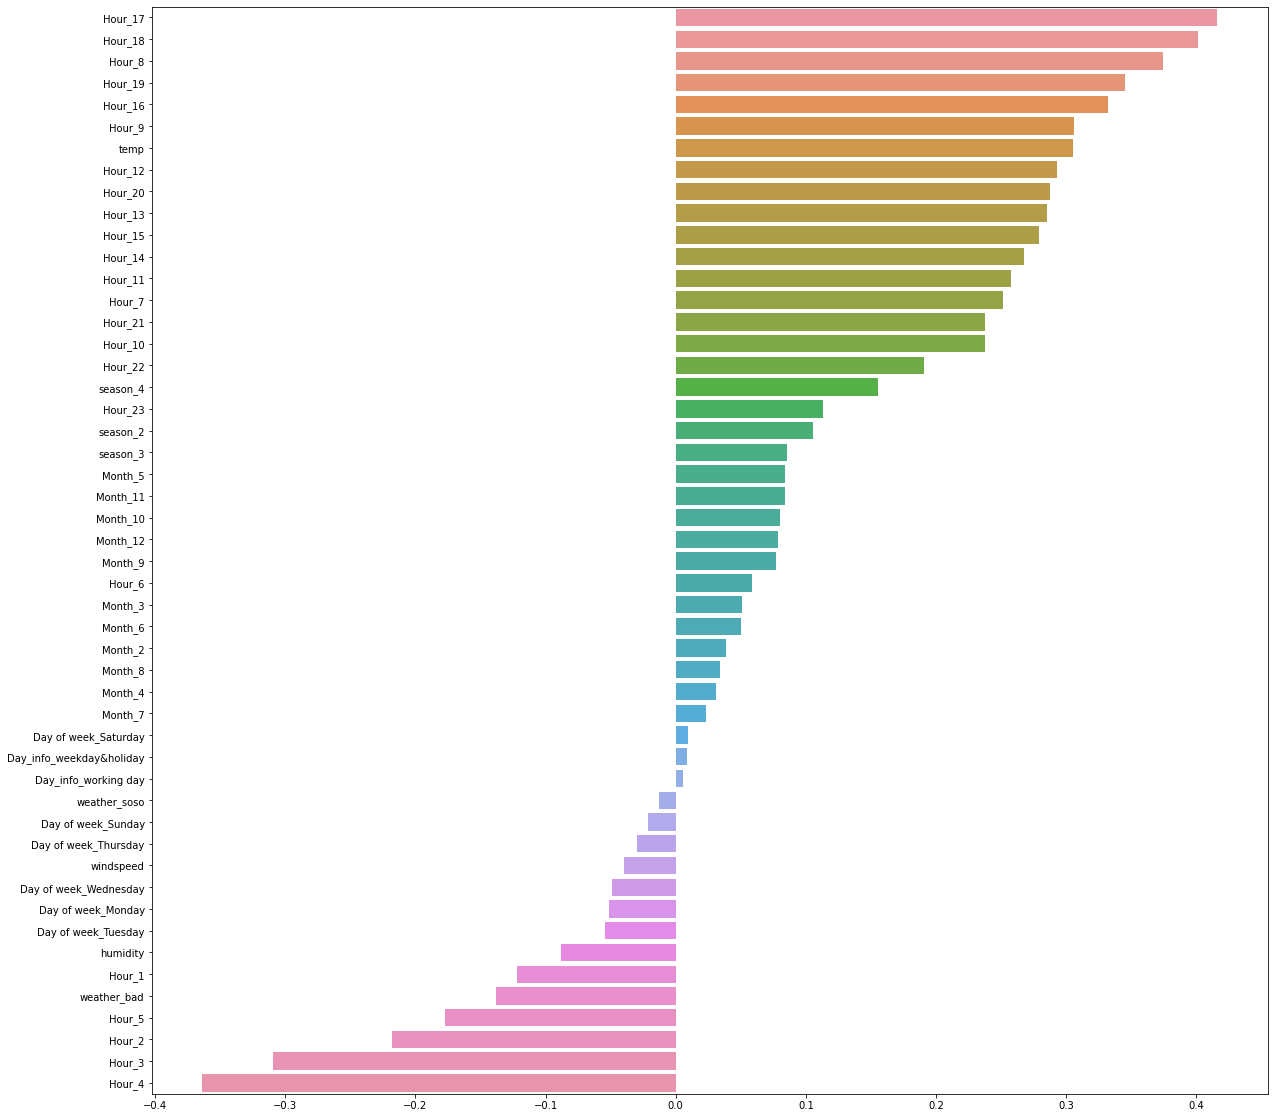

In [ ]:
coeff = pd.Series(data=best_ridge.coef_, index=X_train.columns)
coeff = coeff.sort_values(ascending=False)
plt.subplots(figsize = (20,20))
sns.barplot(x=coeff.values, y=coeff.index)

#즉, cos_hour, sin_hour가 3사 분면인 12 ~ 6 시 사이에는 모델이 자전거를 빌리는쪽으로 예측! 

In [ ]:
coeff_df = coeff.to_frame()
coeff_df.columns = ["Ridge"]
coeff_df
#df_left.join(df_right, how='inner')

,Ridge
Hour_17,0.415955
Hour_18,0.401078
Hour_8,0.374541
Hour_19,0.345222
Hour_16,0.332087
Hour_9,0.305874
temp,0.304975
Hour_12,0.292967
Hour_20,0.287487
Hour_13,0.285640


In [ ]:
coeff_df.to_csv("coeff_cos.csv")

### Laso

In [ ]:
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

#cat features
# cat_col = ["season", "Year","weather", "Day of week","Month","Day_info"] #Hour
# for col in cat_col:
#     train[col] = train[col].astype("category")
#     test[col] = test[col].astype("category")

#train, valid split
days = list(range(1, 15))
train_d = train.loc[train['Day'].isin(days)]
test_d = train.loc[~(train['Day'].isin(days))]

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year",target_col,"sin_hour", "cos_hour"] #"sin_hour", "cos_hour"

x_train, y_train = train_d.drop(drop_cols, axis=1), train_d[target_col]
x_test, y_test = test_d.drop(drop_cols, axis=1), test_d[target_col]

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

x_train.head()

,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,1,Good,9.84,81,0.0,Saturday,1,0,Weekend
1,1,Good,9.02,80,0.0,Saturday,1,1,Weekend
2,1,Good,9.02,80,0.0,Saturday,1,2,Weekend
3,1,Good,9.84,75,0.0,Saturday,1,3,Weekend
4,1,Good,9.84,75,0.0,Saturday,1,4,Weekend


In [ ]:
cat_col = ["season", "weather", "Day of week", "Month", "Day_info","Hour"] #"Hour"

test = pd.get_dummies(test, columns=cat_col, drop_first=True)
train = pd.get_dummies(train, columns=cat_col, drop_first=True)

x_test = pd.get_dummies(x_test, columns=cat_col, drop_first=True)
x_train = pd.get_dummies(x_train, columns=cat_col, drop_first=True)

x_train.head()

,temp,humidity,windspeed,season_2,season_3,season_4,weather_bad,weather_soso,Day of week_Monday,Day of week_Saturday,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,9.84,81,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,9.02,80,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,9.02,80,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9.84,75,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,9.84,75,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    # -- Instantiate dimensionality reduction
    #  (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, x_train.shape[1]) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    lr_alpha=trial.suggest_float("lr_alpha", 0.001, 1)


    estimator=Lasso(alpha=lr_alpha)

    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator) #dimen_red_algorithm

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, x_train, np.log1p(y_train), scoring=rmsle_scorer, cv= KFold(n_splits=5, shuffle=True, random_state=42))
    return -score.mean()

#OPTUNA
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize",
                            sampler=sampler)
study.optimize(objective, n_trials=100)

print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-03-23 11:19:29,247] A new study created in memory with name: no-name-82d14404-c0b3-4417-91c9-efaac06d84da
[I 2023-03-23 11:19:30,002] Trial 0 finished with value: 1.166735926356147 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 9, 'lr_alpha': 0.05902552855603126}. Best is trial 0 with value: 1.166735926356147.
[I 2023-03-23 11:19:30,351] Trial 1 finished with value: 1.427634565965556 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lr_alpha': 0.8326101981596213}. Best is trial 0 with value: 1.166735926356147.
[I 2023-03-23 11:19:30,678] Trial 2 finished with value: 1.427634565965556 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lr_alpha': 0.43251307362347363}. Best is trial 0 with value: 1.166735926356147.
[I 2023-03-23 11:19:31,034] Trial 3 finished with value: 1.3464169434421553 and parameters: {'scalers': 'standard', 'dim_red': None, 'lr_alpha': 0.4566139142328189}. Best is trial 0 with value: 1.166735926356147.
[I 2023-03-23 1

Best Score: 0.6339782004328379
Best trial: {'scalers': 'standard', 'dim_red': None, 'lr_alpha': 0.0011397664384890348}


In [ ]:
# scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# fit ridge
best_lasso=Lasso(alpha=study.best_trial.params['lr_alpha'])
best_lasso.fit(x_train_scaled, np.log1p(y_train))

Lasso(alpha=0.0011397664384890348)

In [ ]:
y_test_pred = np.expm1(best_lasso.predict(x_test_scaled))
test_rmsle = np.round(mean_squared_log_error(y_test, y_test_pred, squared=False), 3)
print(f"Test RMSLE: {test_rmsle}")

Test RMSLE: 0.617


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_test_pred, mode="markers", name="predict",
                text=[f"RMSLE {test_rmsle}"],textposition="top center"))
fig.add_trace(go.Scatter(x=y_test, y=y_test, mode="lines", name="real"))
fig.add_annotation(x=10, y=800,
            text=f"RMSLE = {test_rmsle}",
            showarrow=True)
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig.update_layout(title=dict({"text": "Real & Prediction"}))
fig.update_layout(xaxis=dict({"title": "Real"}))
fig.update_layout(yaxis=dict({"title": "Predict"}))
fig.show()

In [ ]:
#다시 data load
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

#cat features
cat_col = ["season", "Year","weather", "Day of week","Month", "Hour","Day_info"]
for col in cat_col:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year","sin_hour", "cos_hour", target_col] #"sin_hour", "cos_hour"

X_train, Y_train = train.drop(drop_cols, axis=1), train[target_col]
X_test = test.drop(["datetime", "workingday", "holiday", "Day", "Year", "sin_hour", "cos_hour"], axis=1) #"sin_hour", "cos_hour"

print(X_train.shape[0]==train.shape[0])
print(X_test.shape[0]==test.shape[0])
X_train.head()

True
True


,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,1,Good,9.84,81,0.0,Saturday,1,0,Weekend
1,1,Good,9.02,80,0.0,Saturday,1,1,Weekend
2,1,Good,9.02,80,0.0,Saturday,1,2,Weekend
3,1,Good,9.84,75,0.0,Saturday,1,3,Weekend
4,1,Good,9.84,75,0.0,Saturday,1,4,Weekend


In [ ]:
#one hot encoding
cat_col = ["season", "weather", "Day of week", "Month", "Day_info",'Hour']

X_test = pd.get_dummies(X_test, columns=cat_col, drop_first=True)
X_train = pd.get_dummies(X_train, columns=cat_col, drop_first=True)

# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit ridge
best_lasso=Lasso(alpha=study.best_trial.params['lr_alpha'])
best_lasso.fit(X_train_scaled, np.log1p(Y_train))

#제출파일
Y_test_pred = np.expm1(best_lasso.predict(X_test_scaled))
test["count"] = Y_test_pred
submission = test[["datetime", "count"]]

#0.899
submission.to_csv("lasso_cos_Hour.csv", index=False)

<Axes: >

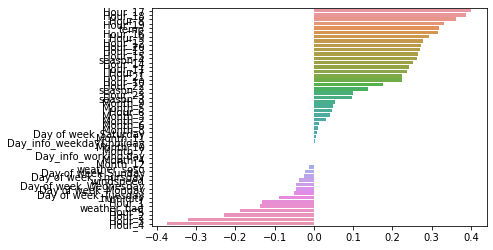

In [ ]:
coeff = pd.Series(data=best_lasso.coef_, index=X_train.columns)
coeff = coeff.sort_values(ascending=False)
sns.barplot(x=coeff.values, y=coeff.index)

In [ ]:
coeff_df_1 = coeff.to_frame()
coeff_df_1.columns = ["Lasso"]
coeff_df = coeff_df_1.join(coeff_df, how='inner')
coeff_df
#df_left.join(df_right, how='inner')

,Lasso,Ridge
Hour_17,0.401140,0.415955
Hour_18,0.386477,0.401078
Hour_8,0.361449,0.374541
Hour_19,0.330954,0.345222
temp,0.318306,0.304975
Hour_16,0.317062,0.332087
Hour_9,0.292353,0.305874
Hour_12,0.278365,0.292967
Hour_20,0.273473,0.287487
Hour_13,0.270764,0.285640


### ElasticNet

In [ ]:
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

#cat features
cat_col = ["season", "Year","weather", "Day of week","Month","Day_info"] #Hour
for col in cat_col:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

#train, valid split
days = list(range(1, 15))
train_d = train.loc[train['Day'].isin(days)]
test_d = train.loc[~(train['Day'].isin(days))]

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year", "sin_hour", "cos_hour",target_col] #"sin_hour", "cos_hour"

x_train, y_train = train_d.drop(drop_cols, axis=1), train_d[target_col]
x_test, y_test = test_d.drop(drop_cols, axis=1), test_d[target_col]

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

x_train.head()

,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,1,Good,9.84,81,0.0,Saturday,1,0,Weekend
1,1,Good,9.02,80,0.0,Saturday,1,1,Weekend
2,1,Good,9.02,80,0.0,Saturday,1,2,Weekend
3,1,Good,9.84,75,0.0,Saturday,1,3,Weekend
4,1,Good,9.84,75,0.0,Saturday,1,4,Weekend


In [ ]:
cat_col = ["season", "weather", "Day of week", "Month", "Day_info","Hour"] #"Hour"

test = pd.get_dummies(test, columns=cat_col, drop_first=True)
train = pd.get_dummies(train, columns=cat_col, drop_first=True)

x_test = pd.get_dummies(x_test, columns=cat_col, drop_first=True)
x_train = pd.get_dummies(x_train, columns=cat_col, drop_first=True)

x_train.head()

,temp,humidity,windspeed,season_2,season_3,season_4,weather_bad,weather_soso,Day of week_Monday,Day of week_Saturday,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,9.84,81,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,9.02,80,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,9.02,80,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9.84,75,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,9.84,75,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    # -- Instantiate dimensionality reduction
    #  (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, x_train.shape[1]) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    lr_alpha=trial.suggest_float("lr_alpha", 0.001, 1)
    lr_ratio=trial.suggest_float("lr_ratio", 0, 1)


    estimator=ElasticNet(alpha=lr_alpha, l1_ratio=lr_ratio)

    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator) #dimen_red_algorithm

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, x_train, np.log1p(y_train), scoring=rmsle_scorer, cv= KFold(n_splits=5, shuffle=True, random_state=42))
    return -score.mean()

#OPTUNA
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize",
                            sampler=sampler)
study.optimize(objective, n_trials=100)

print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-03-23 11:22:08,958] A new study created in memory with name: no-name-c56c81c3-5d37-48e1-acdb-f761eaa3ab09
[I 2023-03-23 11:22:09,366] Trial 0 finished with value: 1.1591221106228065 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 9, 'lr_alpha': 0.05902552855603126, 'lr_ratio': 0.8661761457749352}. Best is trial 0 with value: 1.1591221106228065.
[I 2023-03-23 11:22:09,854] Trial 1 finished with value: 1.145278169273924 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 12, 'lr_alpha': 0.18264314223989353, 'lr_ratio': 0.18340450985343382}. Best is trial 1 with value: 1.145278169273924.
[I 2023-03-23 11:22:10,086] Trial 2 finished with value: 0.7272201525219345 and parameters: {'scalers': 'standard', 'dim_red': None, 'lr_alpha': 0.1403543667913898, 'lr_ratio': 0.29214464853521815}. Best is trial 2 with value: 0.7272201525219345.
[I 2023-03-23 11:22:10,500] Trial 3 finished with value: 1.2809923508156795 and parameters: {'sca

Best Score: 0.6337755135290358
Best trial: {'scalers': 'standard', 'dim_red': None, 'lr_alpha': 0.001120601246454534, 'lr_ratio': 0.5053287577333315}


In [ ]:
study.best_trial.params

{'scalers': 'standard',
 'dim_red': None,
 'lr_alpha': 0.001120601246454534,
 'lr_ratio': 0.5053287577333315}

In [ ]:
# scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# fit 
best_ela=ElasticNet(alpha=study.best_trial.params['lr_alpha'],
           l1_ratio=study.best_trial.params["lr_ratio"])
best_ela.fit(x_train_scaled, np.log1p(y_train))

ElasticNet(alpha=0.001120601246454534, l1_ratio=0.5053287577333315)

In [ ]:
y_test_pred = np.expm1(best_ela.predict(x_test_scaled))
test_rmsle = np.round(mean_squared_log_error(y_test, y_test_pred, squared=False), 3)
print(f"Test RMSLE: {test_rmsle}")

Test RMSLE: 0.617


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_test_pred, mode="markers", name="predict",
                text=[f"RMSLE {test_rmsle}"],textposition="top center"))
fig.add_trace(go.Scatter(x=y_test, y=y_test, mode="lines", name="real"))
fig.add_annotation(x=10, y=800,
            text=f"RMSLE = {test_rmsle}",
            showarrow=True)
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig.update_layout(title=dict({"text": "Real & Prediction"}))
fig.update_layout(xaxis=dict({"title": "Real"}))
fig.update_layout(yaxis=dict({"title": "Predict"}))
fig.show()

In [ ]:
#다시 data load
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

#cat features
cat_col = ["season", "Year","weather", "Day of week","Month", "Hour","Day_info"]
for col in cat_col:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year", "sin_hour", "cos_hour", target_col] #"sin_hour", "cos_hour"

X_train, Y_train = train.drop(drop_cols, axis=1), train[target_col]
X_test = test.drop(["datetime", "workingday", "holiday", "Day", "Year", "sin_hour", "cos_hour"], axis=1) #"sin_hour", "cos_hour"

print(X_train.shape[0]==train.shape[0])
print(X_test.shape[0]==test.shape[0])
X_train.head()

True
True


,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,1,Good,9.84,81,0.0,Saturday,1,0,Weekend
1,1,Good,9.02,80,0.0,Saturday,1,1,Weekend
2,1,Good,9.02,80,0.0,Saturday,1,2,Weekend
3,1,Good,9.84,75,0.0,Saturday,1,3,Weekend
4,1,Good,9.84,75,0.0,Saturday,1,4,Weekend


In [ ]:
#one hot encoding
cat_col = ["season", "weather", "Day of week", "Month", "Day_info",'Hour']

X_test = pd.get_dummies(X_test, columns=cat_col, drop_first=True)
X_train = pd.get_dummies(X_train, columns=cat_col, drop_first=True)

# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit 
best_ela=ElasticNet(alpha=study.best_trial.params['lr_alpha'],
           l1_ratio=study.best_trial.params["lr_ratio"])
best_ela.fit(X_train_scaled, np.log1p(Y_train))

#제출파일
Y_test_pred = np.expm1(best_lasso.predict(X_test_scaled))
test["count"] = Y_test_pred
submission = test[["datetime", "count"]]

#0.899
submission.to_csv("ela_cos_Hour.csv", index=False)

<Axes: >

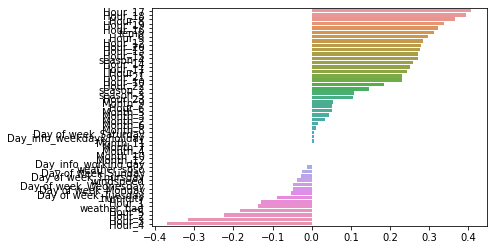

In [ ]:
coeff = pd.Series(data=best_ela.coef_, index=X_train.columns)
coeff = coeff.sort_values(ascending=False)
sns.barplot(x=coeff.values, y=coeff.index)

In [ ]:
coeff_df_1 = coeff.to_frame()
coeff_df_1.columns = ["Elastic"]
coeff_df = coeff_df_1.join(coeff_df, how='inner')
coeff_df
#df_left.join(df_right, how='inner')

,Elastic,Lasso,Ridge
Hour_17,0.407490,0.401140,0.415955
Hour_18,0.392743,0.386477,0.401078
Hour_8,0.367097,0.361449,0.374541
Hour_19,0.337097,0.330954,0.345222
Hour_16,0.323526,0.317062,0.332087
temp,0.312651,0.318306,0.304975
Hour_9,0.298203,0.292353,0.305874
Hour_12,0.284668,0.278365,0.292967
Hour_20,0.279526,0.273473,0.287487
Hour_13,0.277182,0.270764,0.285640


### 그냥 모델

In [ ]:
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

#cat features
# cat_col = ["season", "Year","weather", "Day of week","Month","Day_info"] #Hour
# for col in cat_col:
#     train[col] = train[col].astype("category")
#     test[col] = test[col].astype("category")

#train, valid split
days = list(range(1, 15))
train_d = train.loc[train['Day'].isin(days)]
test_d = train.loc[~(train['Day'].isin(days))]

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year", "sin_hour", "cos_hour",target_col] #"sin_hour", "cos_hour"

x_train, y_train = train_d.drop(drop_cols, axis=1), train_d[target_col]
x_test, y_test = test_d.drop(drop_cols, axis=1), test_d[target_col]

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

x_train.head()

,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,1,Good,9.84,81,0.0,Saturday,1,0,Weekend
1,1,Good,9.02,80,0.0,Saturday,1,1,Weekend
2,1,Good,9.02,80,0.0,Saturday,1,2,Weekend
3,1,Good,9.84,75,0.0,Saturday,1,3,Weekend
4,1,Good,9.84,75,0.0,Saturday,1,4,Weekend


In [ ]:
cat_col = ["season", "weather", "Day of week", "Month", "Day_info","Hour"] #"Hour"

test = pd.get_dummies(test, columns=cat_col, drop_first=True)
train = pd.get_dummies(train, columns=cat_col, drop_first=True)

x_test = pd.get_dummies(x_test, columns=cat_col, drop_first=True)
x_train = pd.get_dummies(x_train, columns=cat_col, drop_first=True)

x_train.head()

,temp,humidity,windspeed,season_2,season_3,season_4,weather_bad,weather_soso,Day of week_Monday,Day of week_Saturday,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,9.84,81,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,9.02,80,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,9.02,80,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9.84,75,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,9.84,75,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_train[["temp", "humidity", "windspeed"]].corr()

,temp,humidity,windspeed
temp,1.000000,-0.066748,-0.017339
humidity,-0.066748,1.000000,-0.313255
windspeed,-0.017339,-0.313255,1.000000


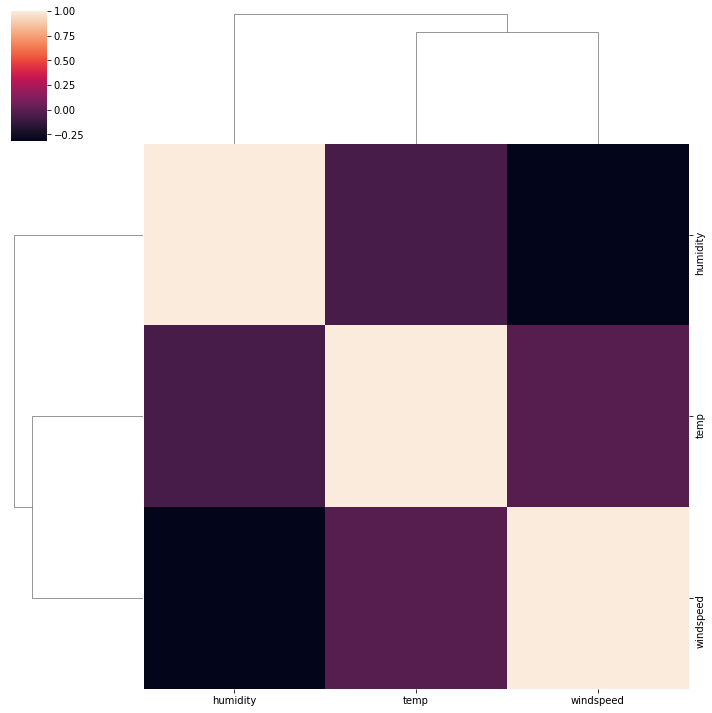

In [ ]:
sns.clustermap(x_train[["temp", "humidity", "windspeed"]].corr())

In [ ]:
# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    # -- Instantiate dimensionality reduction
    #  (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, x_train.shape[1]) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    estimator=LinearRegression()

    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator) #dimen_red_algorithm

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, x_train, np.log1p(y_train), scoring=rmsle_scorer, cv= KFold(n_splits=5, shuffle=True, random_state=42))
    return -score.mean()

#OPTUNA
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize",
                            sampler=sampler)
study.optimize(objective, n_trials=100)

print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-03-23 11:29:58,913] A new study created in memory with name: no-name-7dbfc4fa-e44a-4768-8d4c-41063e84ab79
[I 2023-03-23 11:29:59,825] Trial 0 finished with value: 1.1526018223443548 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 9}. Best is trial 0 with value: 1.1526018223443548.
[I 2023-03-23 11:30:00,679] Trial 1 finished with value: 0.63603082918223 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 49}. Best is trial 1 with value: 0.63603082918223.
[I 2023-03-23 11:30:01,112] Trial 2 finished with value: 0.6342973104569959 and parameters: {'scalers': 'minmax', 'dim_red': None}. Best is trial 2 with value: 0.6342973104569959.
[I 2023-03-23 11:30:01,822] Trial 3 finished with value: 1.3447956277018651 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 16}. Best is trial 2 with value: 0.6342973104569959.
[I 2023-03-23 11:30:02,350] Trial 4 finished with value: 0.6336469904709088 and parameters: 

Best Score: 0.6336469904709088
Best trial: {'scalers': 'robust', 'dim_red': None}


In [ ]:
study.best_trial.params

{'scalers': 'robust', 'dim_red': None}

In [ ]:
# scaling
scaler = RobustScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# fit 
best_model=LinearRegression()
best_model.fit(x_train_scaled, np.log1p(y_train))

LinearRegression()

In [ ]:
y_test_pred = np.expm1(best_model.predict(x_test_scaled))
test_rmsle = np.round(mean_squared_log_error(y_test, y_test_pred, squared=False), 3)
print(f"Test RMSLE: {test_rmsle}")

Test RMSLE: 0.617


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_test_pred, mode="markers", name="predict",
                text=[f"RMSLE {test_rmsle}"],textposition="top center"))
fig.add_trace(go.Scatter(x=y_test, y=y_test, mode="lines", name="real"))
fig.add_annotation(x=10, y=800,
            text=f"RMSLE = {test_rmsle}",
            showarrow=True)
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig.update_layout(title=dict({"text": "Real & Prediction"}))
fig.update_layout(xaxis=dict({"title": "Real"}))
fig.update_layout(yaxis=dict({"title": "Predict"}))
fig.show()

In [ ]:
#다시 data load
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

#cat features
cat_col = ["season", "Year","weather", "Day of week","Month", "Hour","Day_info"]
for col in cat_col:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year", "sin_hour", "cos_hour", target_col] #"sin_hour", "cos_hour"

X_train, Y_train = train.drop(drop_cols, axis=1), train[target_col]
X_test = test.drop(["datetime", "workingday", "holiday", "Day", "Year", "sin_hour", "cos_hour"], axis=1) #"sin_hour", "cos_hour"

print(X_train.shape[0]==train.shape[0])
print(X_test.shape[0]==test.shape[0])
X_train.head()

True
True


,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,1,Good,9.84,81,0.0,Saturday,1,0,Weekend
1,1,Good,9.02,80,0.0,Saturday,1,1,Weekend
2,1,Good,9.02,80,0.0,Saturday,1,2,Weekend
3,1,Good,9.84,75,0.0,Saturday,1,3,Weekend
4,1,Good,9.84,75,0.0,Saturday,1,4,Weekend


In [ ]:
#one hot encoding
cat_col = ["season", "weather", "Day of week", "Month", "Day_info",'Hour']

X_test = pd.get_dummies(X_test, columns=cat_col, drop_first=True)
X_train = pd.get_dummies(X_train, columns=cat_col, drop_first=True)

# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit 
best_model=LinearRegression()
best_model.fit(X_train_scaled, np.log1p(Y_train))

LinearRegression()

In [ ]:
ali = [1, 10, 20, 30]
ali_log = np.log1p(ali)
ali_log_ex = np.expm1(ali_log)

print(ali_log)
print(ali_log_ex)

[0.69314718 2.39789527 3.04452244 3.4339872 ]
[ 1. 10. 20. 30.]


In [ ]:
Y_test_pred = np.expm1(best_model.predict(X_test_scaled))

<ipython-input-149-6e9b4212c5b7>:1: RuntimeWarning:

overflow encountered in expm1



In [ ]:
best_model.coef_

array([ 3.01620937e-01, -8.70727149e-02, -3.89019616e-02, -9.77704614e+11,
        2.17291306e+12,  4.14139386e+12, -1.37484338e-01, -1.43787089e-02,
       -5.13635570e-02, -1.02806196e+13, -1.02671394e+13, -2.79545762e-02,
       -5.60935304e-02, -4.67838281e-02,  4.02630852e-02,  5.37752632e-02,
        6.23750714e+11,  6.24685217e+11,  6.24685217e+11, -1.38834025e+12,
       -1.38834025e+12, -1.38626335e+12, -2.64442245e+12, -2.64442245e+12,
       -2.64574080e+12, -4.85706502e+12, -1.35905223e+13, -1.18286668e-01,
       -2.10630490e-01, -3.07415810e-01, -3.62361458e-01, -1.77655459e-01,
        6.23556531e-02,  2.54796704e-01,  3.75356726e-01,  3.07579500e-01,
        2.39258183e-01,  2.60181794e-01,  2.97909799e-01,  2.89023138e-01,
        2.70954504e-01,  2.86338868e-01,  3.37943033e-01,  4.16687604e-01,
        4.03364440e-01,  3.45053944e-01,  2.92746374e-01,  2.37946045e-01,
        1.88889742e-01,  1.14116619e-01])

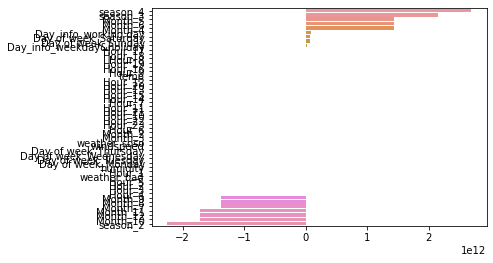

In [ ]:
coeff = pd.Series(data=best_model.coef_, index=X_train.columns)
coeff = coeff.sort_values(ascending=False)
sns.barplot(x=coeff.values, y=coeff.index)

coeff_df_1 = coeff.to_frame()
coeff_df_1.columns = ["Linear"]
coeff_df = coeff_df_1.join(coeff_df, how='inner')

In [ ]:
#one hot encoding
cat_col = ["season", "weather", "Day of week", "Month", "Day_info",'Hour']

# X_test = pd.get_dummies(X_test, columns=cat_col, drop_first=True)
# X_train = pd.get_dummies(X_train, columns=cat_col, drop_first=True)

# scaling
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit 
best_model=LinearRegression()
best_model.fit(X_train_scaled, np.log1p(Y_train))

#제출파일
Y_test_pred = np.expm1(best_model.predict(X_test_scaled))
test["count"] = Y_test_pred
submission = test[["datetime", "count"]]

#0.899
submission.to_csv("LINEAR_cos_Hour.csv", index=False)

<ipython-input-159-e34fb4d6d8ac>:18: RuntimeWarning:

overflow encountered in expm1



In [ ]:
coeff = pd.Series(data=best_model.coef_, index=X_train.columns)
coeff = coeff.sort_values(ascending=False)
coeff_df['Linear'] = coeff

array([ 3.03673385e+00,  2.56170182e+00,  2.07388959e+00, ...,
       -1.26097990e+12, -1.26097990e+12, -1.26097990e+12])

In [ ]:
# scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# fit 
best_model=LinearRegression()
best_model.fit(x_train_scaled, np.log1p(y_train))
y_test_pred = np.expm1(best_model.predict(x_test_scaled))
test_rmsle = np.round(mean_squared_log_error(y_test, y_test_pred, squared=False), 3)
print(f"Test RMSLE: {test_rmsle}")

Test RMSLE: 0.617


<Axes: >

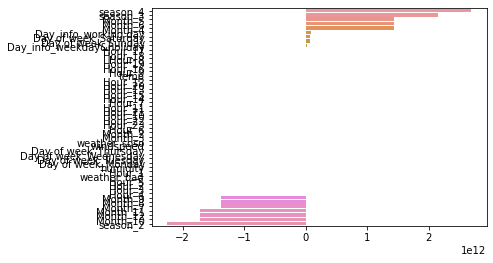

In [ ]:
coeff = pd.Series(data=best_model.coef_, index=X_train.columns)
coeff = coeff.sort_values(ascending=False)
sns.barplot(x=coeff.values, y=coeff.index)

In [ ]:
pd.Series(best_model.predict(X_test_scaled)).value_counts()

 1.318524e+12    3
 9.744932e+11    3
 7.789785e+11    3
-2.253395e+12    3
 7.789785e+11    3
                ..
 7.817787e+11    1
 7.817787e+11    1
 7.817787e+11    1
 7.817787e+11    1
-1.721059e+12    1
Length: 6314, dtype: int64

In [ ]:
coeff_df.drop(columns = 'Linear',axis=1,inplace = True)

In [ ]:
coeff_df.to_csv("회귀계수2.csv")